
## colab에서 실행하기 
## Reference : https://www.tensorflow.org/text/tutorials/transformer

# 라이브러리 설치

In [1]:
!pip install -q tensorflow_datasets
!pip install -U tensorflow-text==2.7.3          # inport 에러나면 2.13.0

^C


     ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
     -- ------------------------------------- 0.2/2.5 MB 4.6 MB/s eta 0:00:01
     ---- ----------------------------------- 0.3/2.5 MB 3.2 MB/s eta 0:00:01
     ------ --------------------------------- 0.4/2.5 MB 3.4 MB/s eta 0:00:01
     ---------- ----------------------------- 0.6/2.5 MB 3.7 MB/s eta 0:00:01
     --------------- ------------------------ 1.0/2.5 MB 4.4 MB/s eta 0:00:01
     ----------------------- ---------------- 1.4/2.5 MB 5.4 MB/s eta 0:00:01
     ------------------------------ --------- 1.9/2.5 MB 5.5 MB/s eta 0:00:01
     ---------------------------------- ----- 2.2/2.5 MB 5.8 MB/s eta 0:00:01
     ---------------------------------------  2.5/2.5 MB 5.9 MB/s eta 0:00:01
     ---------------------------------------- 2.5/2.5 MB 5.7 MB/s eta 0:00:00
     ---------------------------------------- 0.0/436.8 MB ? eta -:--:--
     --------------------------------------- 0.5/436.8 MB 14.2 MB/s eta 0:00

ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\lenovo\\anaconda3\\Lib\\site-packages\\tensorflow\\lite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



# 라이브러리 import

In [ ]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

# 로거 설정

In [ ]:
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress warnings

# 포르투칼어-영어 번역 데이터셋을 다운로드합니다.
## Refernece : 
1. https://github.com/neulab/word-embeddings-for-nmt
2. https://www.ted.com/participate/translate

### 50000개의 training 데이터와 1100개의 validation 데이터, 2000개의 테스트 데이터를 가지고 있습니다.

In [ ]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True)
train_examples, val_examples = examples['train'], examples['validation']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete76C32V/ted_hrlr_translate-train.tfrecord


  0%|          | 0/51785 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete76C32V/ted_hrlr_translate-validation.tfrecord


  0%|          | 0/1193 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incomplete76C32V/ted_hrlr_translate-test.tfrecord


  0%|          | 0/1803 [00:00<?, ? examples/s]

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


# Sanity check를 위해 trianing data에 있는 3개의 문장을 살펴봅니다.

In [ ]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))

  print()

  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


# text 데이터를 numeric 데이터로 변경하기 위한 Tokenizer를 다운로드받고 불러옵니다.

In [ ]:
model_name = "ted_hrlr_translate_pt_en_converter"
tf.keras.utils.get_file(
    f"{model_name}.zip",
    f"https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip",
    cache_dir='.', cache_subdir='', extract=True
)

188416/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [ ]:
tokenizers = tf.saved_model.load(model_name)

In [ ]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

# 예제 데이터를 통한 Tokenizer 사용법 익히기

In [ ]:
for en in en_examples.numpy():
  print(en.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [ ]:
encoded = tokenizers.en.tokenize(en_examples)

for row in encoded.to_list():
  print(row)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [ ]:
round_trip = tokenizers.en.detokenize(encoded)
for line in round_trip.numpy():
  print(line.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [ ]:
tokens = tokenizers.en.lookup(encoded)
tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability', b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage', b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip', b'##ity', b'.', b'[END]'], [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?', b'[END]'], [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for', b'curiosity', b'.', b'[END]']]>

# Training에 사용할 pipeline 구축을 위한 tokenizing 함수 정의

In [ ]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    # Convert from ragged to dense, padding with zeros.
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    # Convert from ragged to dense, padding with zeros.
    en = en.to_tensor()
    return pt, en

# Batch Size 및 batch 생성 함수 정의

In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [ ]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

# 위치 인코딩(Positional Encoding)을 위한 함수 정의


$$\Large{PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


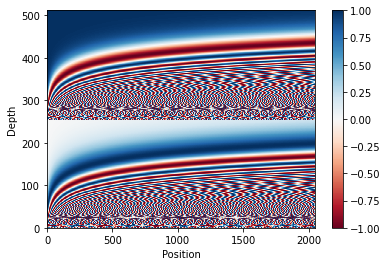

In [ ]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# 길이를 맞추기 위해 Padding으로 설정한 부분을 체크하기 위한 mask 함수를 정의합니다.

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

# Transformer 모델이 미래 단어를 예측에 사용하지 않도록 Look ahead 마스크를 정의합니다.

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [ ]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# Scaled Dot-Product Attention을 정의합니다.
<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

$$\Large{Attention(Q, K, V) = softmax_k\left(\frac{QK^T}{\sqrt{d_k}}\right) V} $$

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [ ]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10, 0, 0],
                      [0, 10, 0],
                      [0, 0, 10],
                      [0, 0, 10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[1, 0],
                      [10, 0],
                      [100, 5],
                      [1000, 6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [ ]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [ ]:
temp_q = tf.constant([[0, 0, 10],
                      [0, 10, 0],
                      [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


# Multi-head Attention을 정의합니다.
<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

# MultiHeadAttention을 테스트합니다.

In [ ]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

# Point wise feed forward network를 정의합니다.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Point wise feed forward network 를 테스트합니다.

In [ ]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

# Encoder Layer를 정의합니다.
<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

# Encoder 레이어를 테스트합니다.

In [ ]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

# Decoder 레이어를 정의합니다.


In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

# Decoder 레이어를 테스트합니다.


In [ ]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

# Encoder를 정의합니다.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

# Encoder를 테스트합니다.

In [ ]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 62, 512)


# Decoder를 정의합니다.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

# Decoder를 테스트합니다.

In [ ]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
                         dff=2048, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

# Transformer를 정의합니다.

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask,
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

# Transformer를 테스트합니다.

In [ ]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

# Transformer의 하이퍼 파라미터 설정값들을 정의합니다.

In [ ]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

# Adam Optimizer를 위한 Custom Learning Rate를 설정합니다.
$$\Large{lrate = d_{model}^{-0.5} * \min(step{\_}num^{-0.5}, step{\_}num \cdot warmup{\_}steps^{-1.5})}$$


In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

# Custom Learning Rate를 테스트합니다.

Text(0.5, 0, 'Train Step')

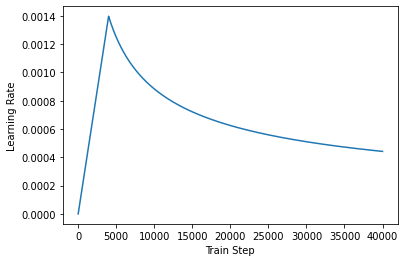

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

# Loss를 정의합니다.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

# Loss와 Accuracy Function을 정의합니다.

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

# Transformer 모델을 선언합니다.

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.pt.get_vocab_size(),
    target_vocab_size=tokenizers.en.get_vocab_size(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

# mask 생성 function을 정의합니다.

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

# 파라미터 저장을 위한 체크포인트를 설정합니다.

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

# Epoch 횟수(=20)을 지정합니다.

In [ ]:
EPOCHS = 20

# 트레이닝을 위한 train step을 정의합니다.

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

# Epoch 횟수 만큼 트레이닝을 진행합니다.

In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8668 Accuracy 0.0000
Epoch 1 Batch 50 Loss 8.8126 Accuracy 0.0009
Epoch 1 Batch 100 Loss 8.7117 Accuracy 0.0212
Epoch 1 Batch 150 Loss 8.5968 Accuracy 0.0296
Epoch 1 Batch 200 Loss 8.4568 Accuracy 0.0336
Epoch 1 Batch 250 Loss 8.2874 Accuracy 0.0361
Epoch 1 Batch 300 Loss 8.0981 Accuracy 0.0378
Epoch 1 Batch 350 Loss 7.9027 Accuracy 0.0401
Epoch 1 Batch 400 Loss 7.7139 Accuracy 0.0486
Epoch 1 Batch 450 Loss 7.5443 Accuracy 0.0580
Epoch 1 Batch 500 Loss 7.3967 Accuracy 0.0666
Epoch 1 Batch 550 Loss 7.2595 Accuracy 0.0753
Epoch 1 Batch 600 Loss 7.1331 Accuracy 0.0835
Epoch 1 Batch 650 Loss 7.0149 Accuracy 0.0915
Epoch 1 Batch 700 Loss 6.9059 Accuracy 0.0988
Epoch 1 Batch 750 Loss 6.8068 Accuracy 0.1053
Epoch 1 Batch 800 Loss 6.7128 Accuracy 0.1115
Epoch 1 Loss 6.6962 Accuracy 0.1126
Time taken for 1 epoch: 246.73 secs

Epoch 2 Batch 0 Loss 5.4083 Accuracy 0.1953
Epoch 2 Batch 50 Loss 5.2072 Accuracy 0.2149
Epoch 2 Batch 100 Loss 5.1901 Accuracy 0.2167
Epoch 2 Batch

# 학습이 끝난 모델의 Evaluation 함수를 정의합니다.

In [ ]:
def evaluate(sentence, max_length=40):
  # inp sentence is portuguese, hence adding the start and end token
  sentence = tf.convert_to_tensor([sentence])
  sentence = tokenizers.pt.tokenize(sentence).to_tensor()

  encoder_input = sentence

  # as the target is english, the first word to the transformer should be the
  # english start token.
  start, end = tokenizers.en.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizers.en.detokenize(output)[0]  # shape: ()

  tokens = tokenizers.en.lookup(output)[0]

  return text, tokens, attention_weights

# 예측 결과를 테스트하기 위한 print 함수를 정의합니다.

In [ ]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [ ]:
sentence = "este é um problema que temos que resolver."
ground_truth = "this is a problem we have to solve ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é um problema que temos que resolver.
Prediction     : this is a problem that we have to solve .
Ground truth   : this is a problem we have to solve .


In [ ]:
sentence = "os meus vizinhos ouviram sobre esta ideia."
ground_truth = "and my neighboring homes heard about this idea ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : os meus vizinhos ouviram sobre esta ideia.
Prediction     : my neighbors heard about this idea .
Ground truth   : and my neighboring homes heard about this idea .


In [ ]:
sentence = "vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram."
ground_truth = "so i \'ll just share with you some stories very quickly of some magical things that have happened ."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Prediction     : so i ' m going to very quickly share with you some stories from some magic things that happen .
Ground truth   : so i 'll just share with you some stories very quickly of some magical things that have happened .


In [ ]:
sentence = "este é o primeiro livro que eu fiz."
ground_truth = "this is the first book i've ever done."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

Input:         : este é o primeiro livro que eu fiz.
Prediction     : this is the first book i did .
Ground truth   : this is the first book i've ever done.


# Prediction 구간동안 Transformer의 Attention이 어느 부분을 집중하는지를 체크하는 attention plot 함수를 정의합니다.

In [ ]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [ ]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([9, 11])

In [ ]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.pt.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'[START]', b'este', b'e', b'o', b'primeiro', b'livro', b'que',
       b'eu', b'fiz', b'.', b'[END]'], dtype=object)>

In [ ]:
translated_tokens

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'[START]', b'this', b'is', b'the', b'first', b'book', b'i',
       b'did', b'.', b'[END]'], dtype=object)>

# Attention이 집중하는 부분을 체크합니다.

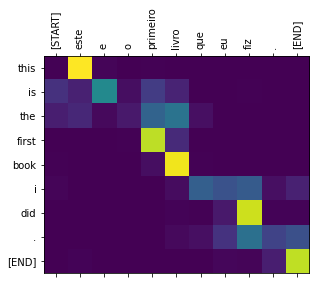

In [ ]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [ ]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.pt.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.pt.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

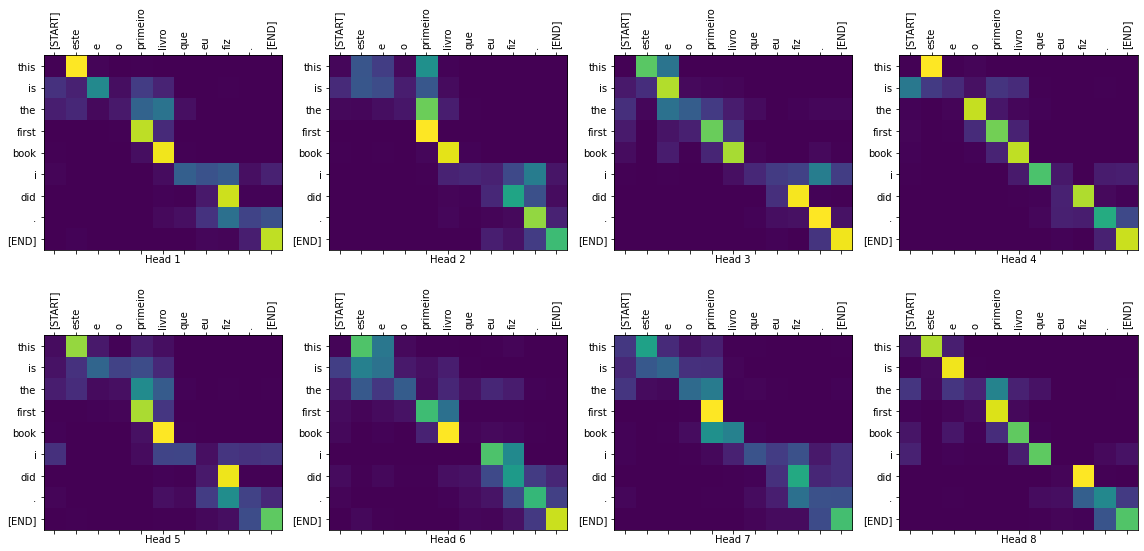

In [ ]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

Input:         : Eu li sobre triceratops na enciclopédia.
Prediction     : i read about trifices in encyclopedia .
Ground truth   : I read about triceratops in the encyclopedia.


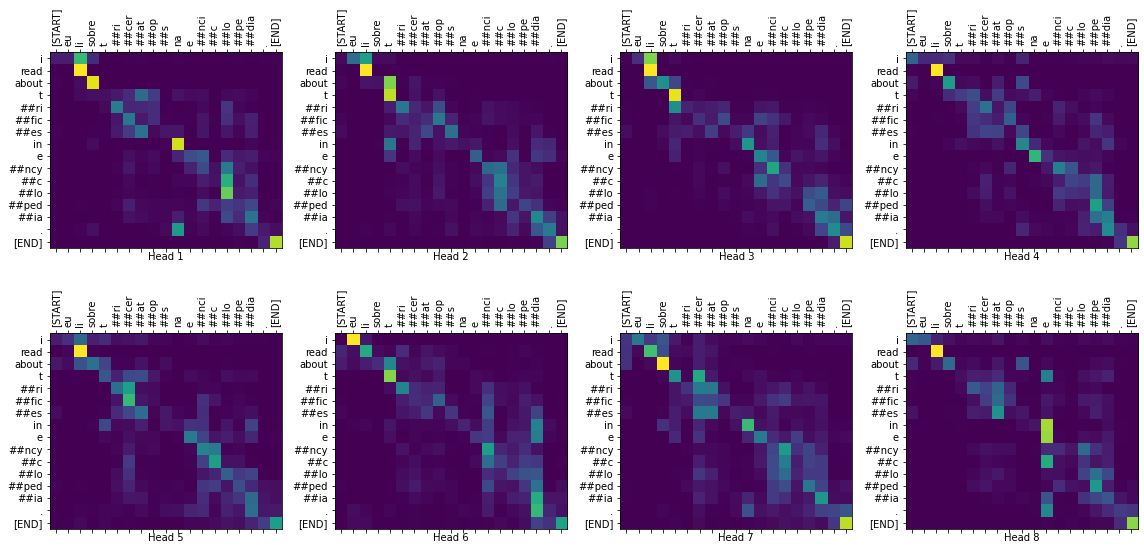

In [ ]:
sentence = "Eu li sobre triceratops na enciclopédia."
ground_truth = "I read about triceratops in the encyclopedia."

translated_text, translated_tokens, attention_weights = evaluate(sentence)
print_translation(sentence, translated_text, ground_truth)

plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])